## 07. cgan data impurity notebook for functionized modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from torch import nn

from cgan import CGAN_Discriminator, CGAN_Generator
from train_cgan import train_model, get_loss
from data_preprocess import split_target_condition, minmax_scaler, data_batch
from generate_data import generate_samples

/Users/emilymiura/opt/anaconda3/envs/dowgan/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### loading / visualizing data

In [2]:
df = pd.read_csv(r'/Users/emilymiura/dowgan-ems/notebooks/ems-experiments/dataimpurity.csv', 
                 delimiter='\t')

In [3]:
#Dropping date column and putting column names in a list bc they are so long
data = df.drop(df.columns[0],axis=1)
# time = np.arange(0,len(data))
# data.insert(0,'Time',time)

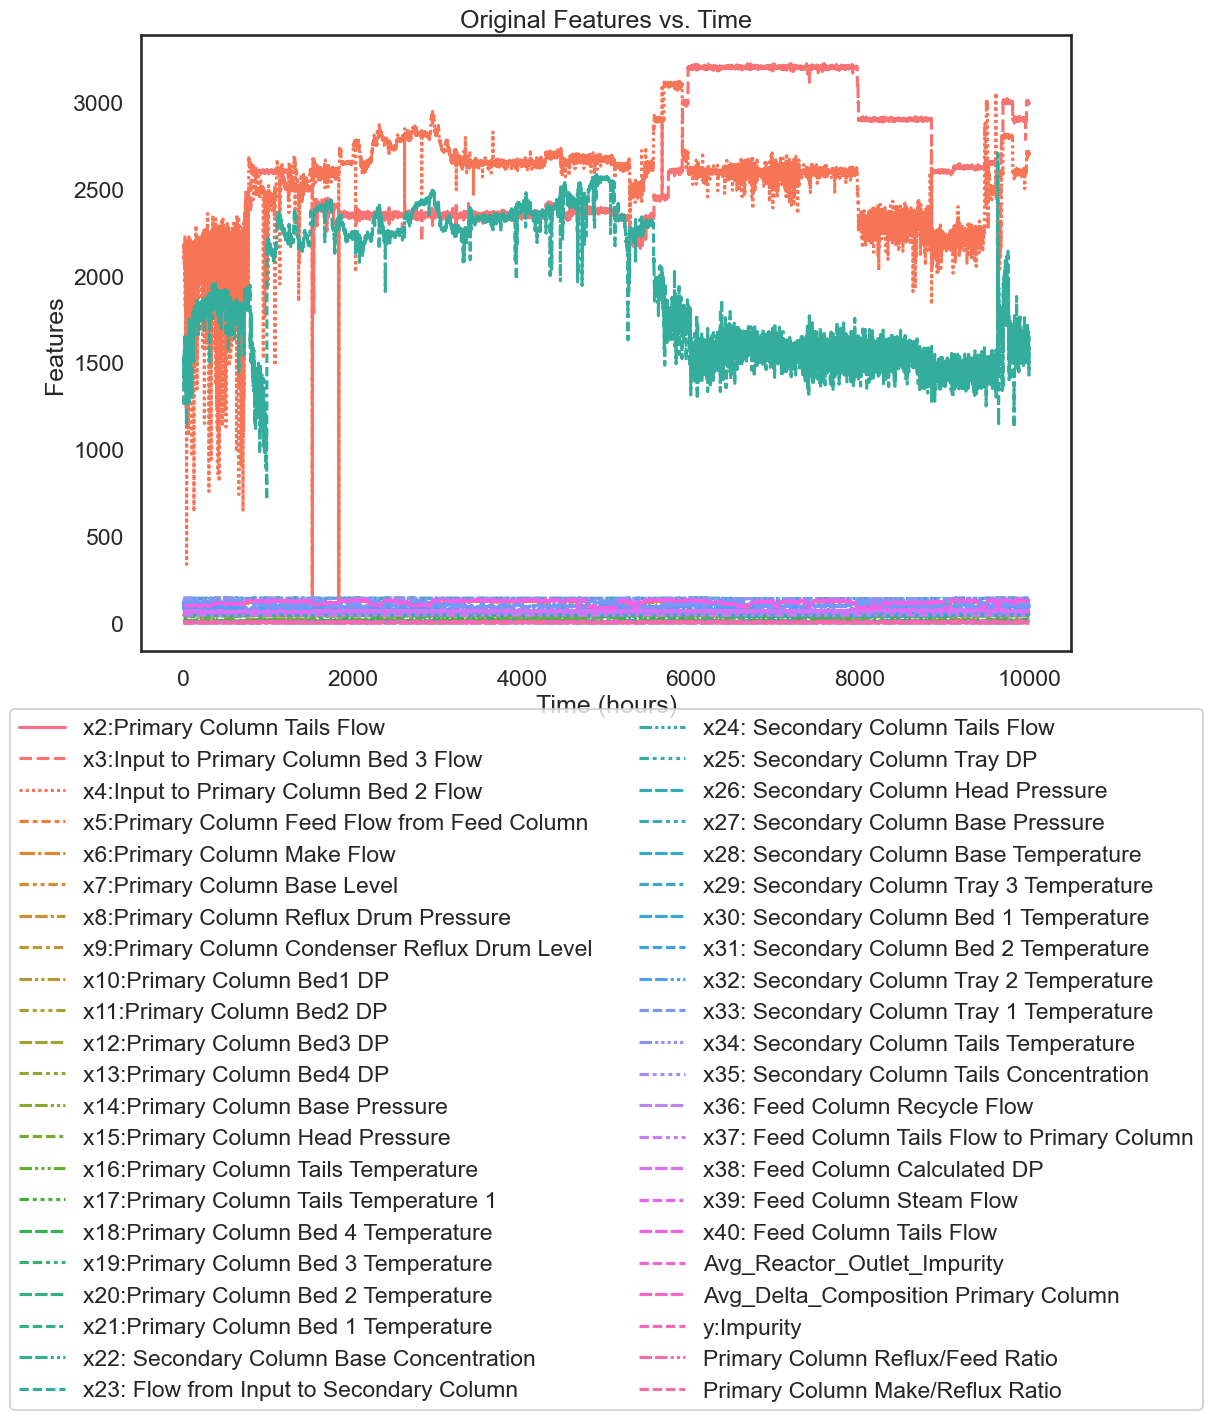

In [4]:
# plotting original data vs time for first 500 points
plt.figure(figsize=(12,8))
sns.lineplot(data=data.iloc[0:10000,1:45])
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -1.25), ncols=2)
plt.title('Original Features vs. Time')
plt.xlabel('Time (hours)')
plt.ylabel('Features');

### defining global variables and parameters

In [5]:
print("defining some GLOBAL VARIABLES to be used for the rest of the model")
N_TIMEPOINTS = 24
BATCH_SIZE = 20

print(f"number of time points per sample: {N_TIMEPOINTS}")
print(f"number of samples per batch: {BATCH_SIZE}")

# training parameters
EPOCHS = 50
LEARNING_RATE = 0.002

print(f"number of epochs: {EPOCHS}")
print(f"learning rate: {LEARNING_RATE}")

# model parameters
INPUT_SHAPE = 46
HIDDEN_UNITS = 8
OUTPUT_SHAPE_D = 1
OUTPUT_SHAPE_G = 45



defining some GLOBAL VARIABLES to be used for the rest of the model
number of time points per sample: 24
number of samples per batch: 20
number of epochs: 50
learning rate: 0.002


### data preprocessing

In [6]:
print("splitting data between targets and conditions...")
targets, conditions = split_target_condition(data, condition='Class')

splitting data between targets and conditions...
shape of targets (all features without operating conditions): (10177, 45)
shape of conditions (operating conditions): (10177,)


In [7]:
print("scaling data and converting to tensors for batching & dataloader...")
target_tensor, conditions_tensor, scaler = minmax_scaler(target_data=targets,
                                                 condition_data=conditions,
                                                 min=0,
                                                 max=1)

scaling data and converting to tensors for batching & dataloader...
data is scaled and converted to tensors!
ready for batching and dataloader
shape of target (tensor): torch.Size([10177, 45])
shape of condition (tensor): torch.Size([10177, 1])


In [8]:
print("batching data and generating a dataloader...")
dataloader = data_batch(target_tensor=target_tensor,
                        conditions_tensor=conditions_tensor,
                        n_datapoints=N_TIMEPOINTS,
                        batch_size=BATCH_SIZE)

batching data and generating a dataloader...
length of data: 10177
We have 368 samples with 24 datapoints in each.
There are 56 invalid batches.

dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7fca33b79f10>
length of train_dataloader: 19 batches of 20 (batch_size) examples
number of total examples: 368 
each example containing... 
TARGET shape (number of timepoints): torch.Size([24, 45]) 
CONDITION shape (class 1 or 2): torch.Size([24, 1])


### defining D. and G. models and training

In [9]:
netG = CGAN_Generator(input_shape=INPUT_SHAPE, 
                      hidden_units=HIDDEN_UNITS, 
                      output_shape=OUTPUT_SHAPE_G)
netG

CGAN_Generator(
  (main): Sequential(
    (0): ConvTranspose1d(46, 8, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): ConvTranspose1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Conv1d(8, 45, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (sigmoid): Sigmoid()
)

In [10]:
netD = CGAN_Discriminator(input_shape=INPUT_SHAPE, 
                          hidden_units=HIDDEN_UNITS, 
                          output_shape=OUTPUT_SHAPE_D)
netD

CGAN_Discriminator(
  (main): Sequential(
    (0): Conv1d(46, 8, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv1d(8, 8, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
    (3): LeakyReLU(negative_slope=0.2)
    (4): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Dropout(p=0.2, inplace=False)
  )
  (linearize): Sequential(
    (0): Linear(in_features=24, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [11]:
# running training loop
D_loss, G_loss = train_model(
    generator_model=netG,
    discriminator_model=netD,
    dataloader=dataloader,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE
)

 20%|██        | 10/50 [00:06<00:22,  1.81it/s]

Epoch: 10/50 | D_loss: 0.6882 | G_loss: 0.2383


 40%|████      | 20/50 [00:11<00:17,  1.73it/s]

Epoch: 20/50 | D_loss: 0.6884 | G_loss: 0.3221


 60%|██████    | 30/50 [00:17<00:11,  1.74it/s]

Epoch: 30/50 | D_loss: 0.6524 | G_loss: 0.2883


 80%|████████  | 40/50 [00:22<00:05,  1.78it/s]

Epoch: 40/50 | D_loss: 0.6645 | G_loss: 0.4239


100%|██████████| 50/50 [00:29<00:00,  1.70it/s]

Epoch: 50/50 | D_loss: 0.5389 | G_loss: 0.7769


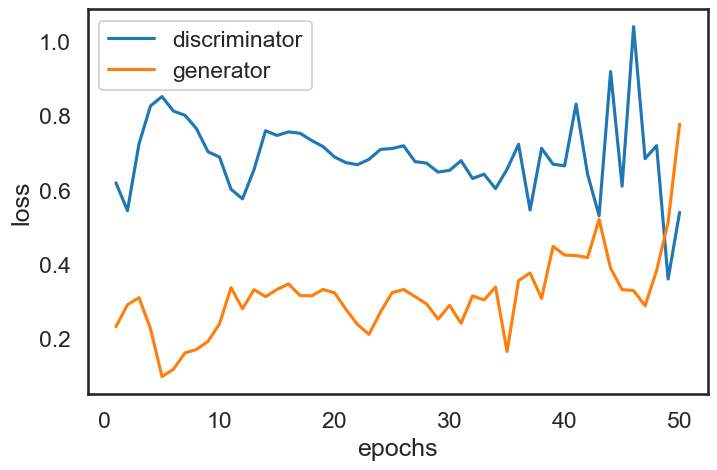

In [12]:
# plotting loss
get_loss(D_loss_list=D_loss,
         G_loss_list=G_loss,
         epochs=EPOCHS)

### using the model to generate data

In [13]:
# extracting column names from original data
column_names = list(data.columns.values[0:45])
column_names

['x1:Primary Column Reflux Flow',
 'x2:Primary Column Tails Flow',
 'x3:Input to Primary Column Bed 3 Flow',
 'x4:Input to Primary Column Bed 2 Flow',
 'x5:Primary Column Feed Flow from Feed Column',
 'x6:Primary Column Make Flow',
 'x7:Primary Column Base Level',
 'x8:Primary Column Reflux Drum Pressure',
 'x9:Primary Column Condenser Reflux Drum Level',
 'x10:Primary Column Bed1 DP',
 'x11:Primary Column Bed2 DP',
 'x12:Primary Column Bed3 DP',
 'x13:Primary Column Bed4 DP',
 'x14:Primary Column Base Pressure',
 'x15:Primary Column Head Pressure',
 'x16:Primary Column Tails Temperature',
 'x17:Primary Column Tails Temperature 1',
 'x18:Primary Column Bed 4 Temperature',
 'x19:Primary Column Bed 3 Temperature',
 'x20:Primary Column Bed 2 Temperature',
 'x21:Primary Column Bed 1 Temperature',
 'x22: Secondary Column Base Concentration',
 'x23: Flow from Input to Secondary Column',
 'x24: Secondary Column Tails Flow',
 'x25: Secondary Column Tray DP',
 'x26: Secondary Column Head Pressu

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


generated_data: (1000, 45)


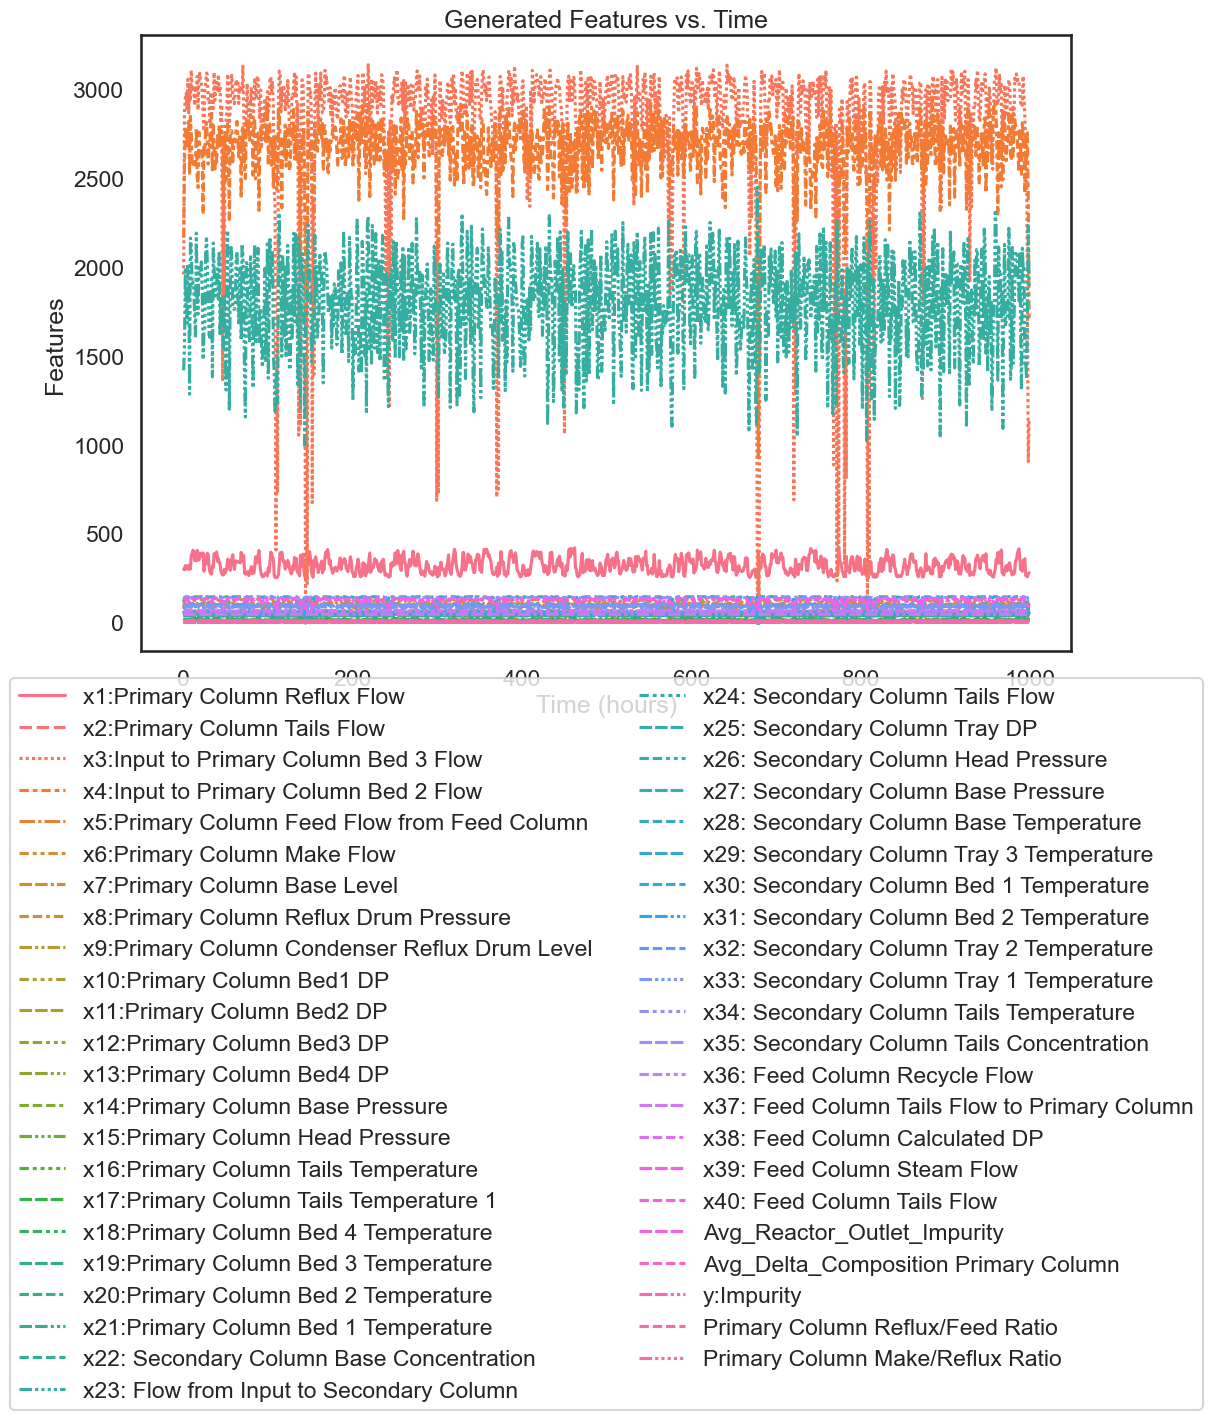

In [14]:
# generating data
generate_samples(generator_model=netG,
                 minmax_scaler=scaler,
                 n_datapoints=1000,
                 n_features=45,
                 column_names=column_names)